# Use this to evaluate our Mask R-CNN model

In [24]:
import os
import sys
import random
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import mammo_baseline

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "mammography", "checkpoints")

# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/mammo")

In [25]:
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Notebook Preferences

In [26]:
DEVICE = "/gpu:0"  #
TEST_MODE = "inference"

In [27]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [28]:
dataset = mammo_baseline.MammoDataset()
dataset.load_mammo(DATASET_DIR, "mass_test", augmented=False)
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

mass_test
Images: 361
Classes: ['BG', 'mass']


## Configurations

In [29]:
# # Inference Configuration
config = mammo_baseline.MammoInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Load Model

In [30]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

## Compute batch AP

In [10]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = np.zeros(10)
    mAPs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        mAP, AP = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        mAPs.append(mAP)
        APs = np.add(APs, AP)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   mAP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], mAP))
    return mAPs,APs

## Evaluate the trained model across all epochs

### Best results usually within first 10 epochs

In [26]:
################################################
## Using trained network on higher res image  ##
##    on normal resolution image (3x dataset) ##
################################################



# Path to a specific weights file
_21aug_high_reso_3x_fix = "mammo20180821T0232"
latest = _21aug_high_reso_3x_fix

epochs_trained = 9
limit = 361

iou_range = np.arange(0.5, 1.0, 0.05)

## We start from epoch 2 since the first epoch takes a long time to compute 
for i in range(2, epochs_trained):
    if i < 10:
        n_epochs = "mask_rcnn_mammo_000" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True) 
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit],verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
    elif i >= 10:
        n_epochs = "mask_rcnn_mammo_00" + str(i) + ".h5"
        weights_path = os.path.join(LOGS_DIR, latest, n_epochs)
        
        print("\n", i, ": Loading weights ", weights_path)
        time_now = time.time()
        model.load_weights(weights_path, by_name=True)       
        mAPs, APs = compute_batch_ap(dataset, dataset.image_ids[:limit], verbose=0)
        for i in range(len(iou_range)):
            print("AP @{:.2f}:\t {:.3f}".format(iou_range[i], (np.sum(APs[i])/limit)))
        print("Mean AP over {} images: {:.4f}".format(len(mAPs), np.mean(mAPs)))
        print("Time taken:", time.time() - time_now)
        


 2 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0002.h5
AP @0.50:	 0.632
AP @0.55:	 0.583
AP @0.60:	 0.525
AP @0.65:	 0.446
AP @0.70:	 0.363
AP @0.75:	 0.259
AP @0.80:	 0.151
AP @0.85:	 0.065
AP @0.90:	 0.011
AP @0.95:	 0.000
Mean AP over 361 images: 0.3036
Time taken: 1262.071620941162

 3 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0003.h5
AP @0.50:	 0.644
AP @0.55:	 0.597
AP @0.60:	 0.535
AP @0.65:	 0.446
AP @0.70:	 0.336
AP @0.75:	 0.231
AP @0.80:	 0.138
AP @0.85:	 0.040
AP @0.90:	 0.001
AP @0.95:	 0.000
Mean AP over 361 images: 0.2968
Time taken: 788.5282146930695

 4 : Loading weights  C:\Users\Chevy\Documents\GitHub\Mammo_MaskRCNN\mammography\checkpoints\mammo20180821T0232\mask_rcnn_mammo_0004.h5
AP @0.50:	 0.659
AP @0.55:	 0.611
AP @0.60:	 0.529
AP @0.65:	 0.401
AP @0.70:	 0.334
AP @0.75:	 0.219
AP @0.80:	 0.115
AP @0.

## Visualize predictions

Image ID: 115
image ID: mass.P_01684_LEFT_MLO (115) P_01684_LEFT_MLO
Original image shape:  [1024  671    3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detections: (1, 100, 6)
mrcnn_mask: (1, 100, 28, 28, 2)
AP @0.50:	 1.000
AP @0.55:	 1.000
AP @0.60:	 1.000
AP @0.65:	 1.000
AP @0.70:	 1.000
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.500
['mass', 'mass 0.96 / 0.74', 'mass 0.86 / 0.00', 'mass 0.81 / 0.00', 'mass 0.72 / 0.00']


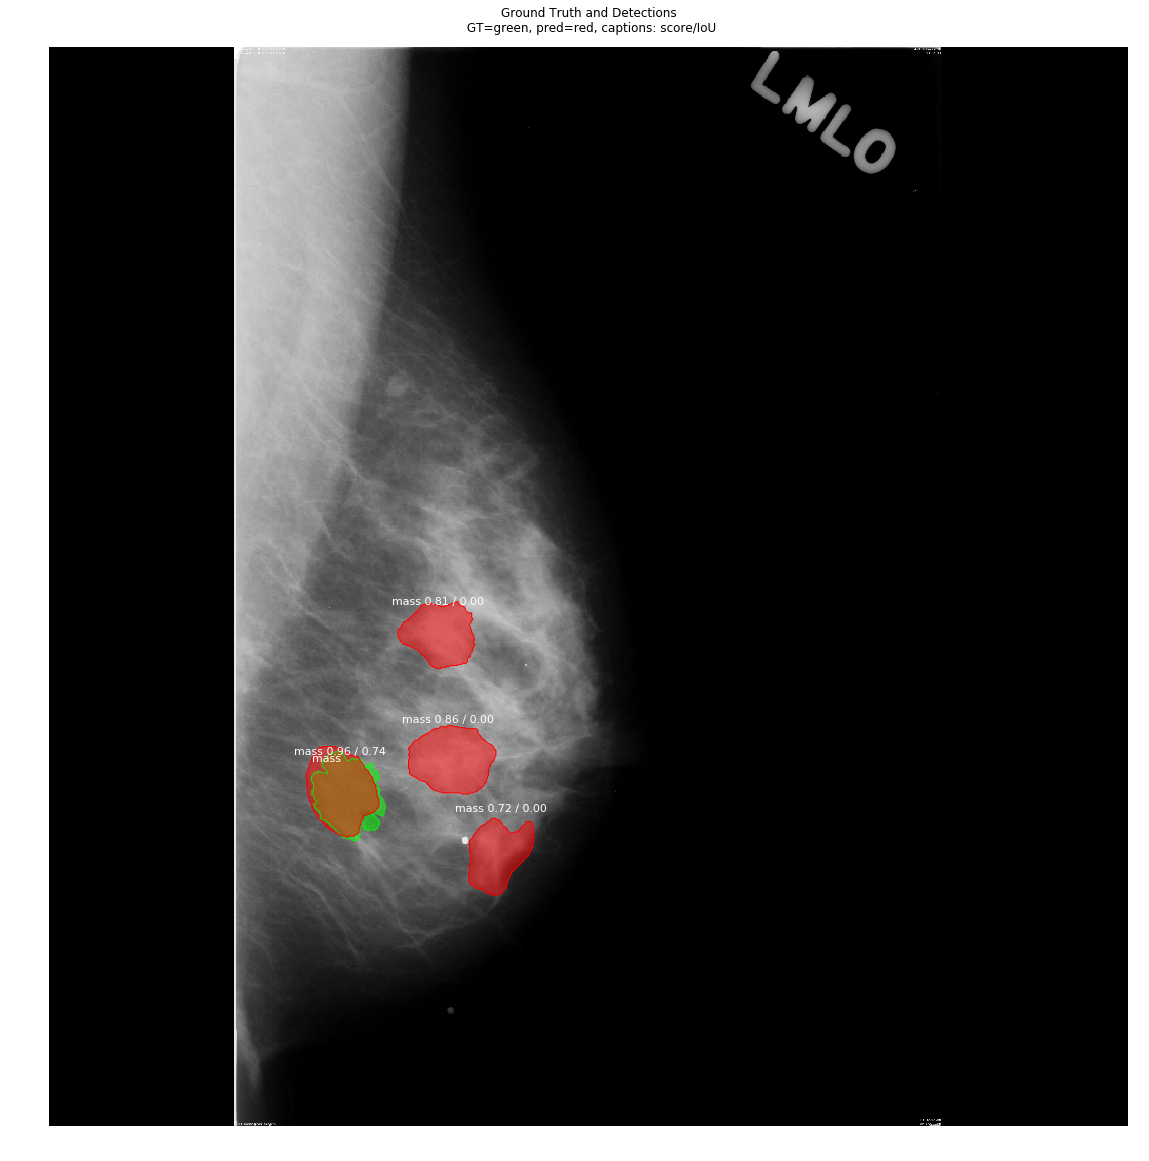

In [23]:
image_id = random.choice(dataset.image_ids)
print("Image ID:", image_id)
latest = "mammo20180821T0232"
n_epochs = "mask_rcnn_mammo_000" + str(5) + ".h5"
weights_path = os.path.join(LOGS_DIR, latest, n_epochs)

model.load_weights(weights_path, by_name=True) 


image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# # Display results
r = results[0]
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# # Compute AP over range 0.5 to 0.95 and print it
mAP, AP = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)


visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=True,
    iou_threshold=0.5, score_threshold=0.9)